In [1]:
from typing import List
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.CIFAR10(
    root="../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)


In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

        self.sub_decoder_1 = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

        self.sub_decoder_2 = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        z1 = encoded[:, :5]
        z2 = encoded[:, 5:]
        decoded_1 = self.sub_decoder_1(z1)
        decoded_2 = self.sub_decoder_2(z2)
        return decoded, decoded_1, decoded_2, encoded

In [ ]:
model = autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model.to(device)

Cuda Avalible


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_f

In [ ]:
for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 3 * 32 * 32).to(device)
        reconstructed, first_recon, second_recon ,represent = model(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    outputs.append((epoch, images, reconstructed, first_recon, second_recon, represent))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

/home/nicek/Projects/encoder/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 5])) that is different to the input size (torch.Size([32, 3072])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3072) must match the size of tensor b (5) at non-singleton dimension 1

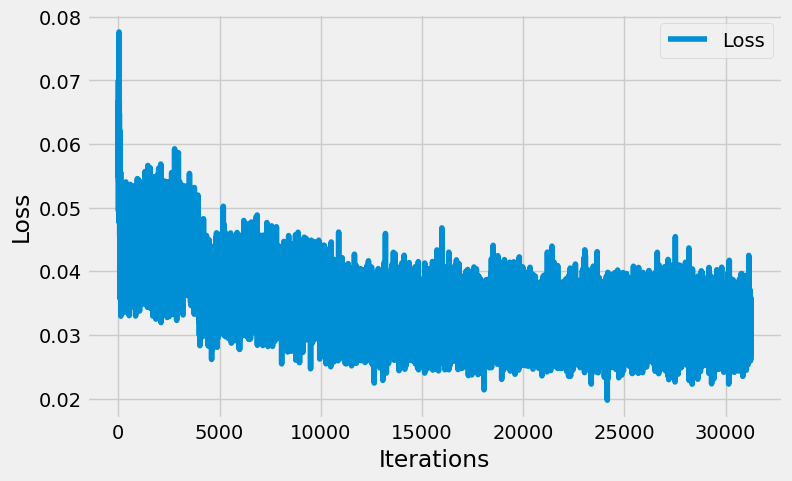

In [11]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

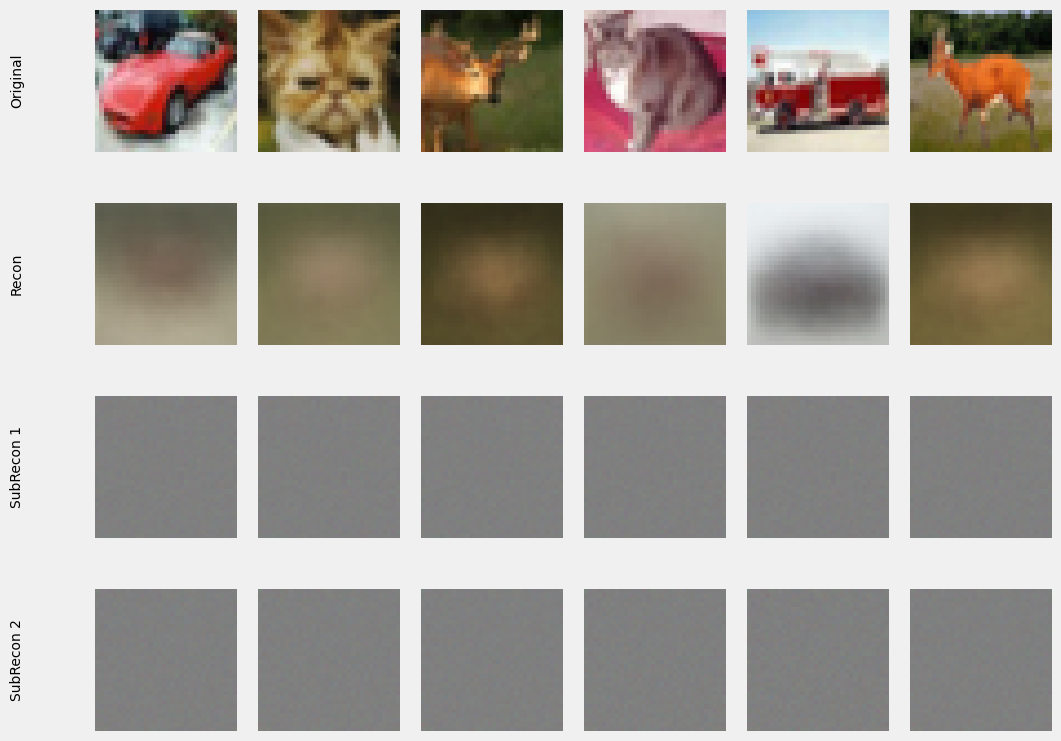

In [ ]:
epoch_idx, original_imgs, recon_imgs, first_recon, second_recon, represent = outputs[-1]
n = min(6, original_imgs.size(0))  


original_imgs = original_imgs[:n].detach().cpu().view(-1, 3, 32, 32)
recon_imgs = recon_imgs[:n].detach().cpu().view(-1, 3, 32, 32)
first_recon = first_recon[:n].detach().cpu().view(-1, 3, 32, 32)
second_recon = second_recon[:n].detach().cpu().view(-1, 3, 32, 32)
represent = represent[:n].detach().cpu()  



image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("SubRecon 1", first_recon),
    ("SubRecon 2", second_recon)
]


# rows = len(image_sets)
# plt.figure(figsize=(1.8 * n, 2 * rows))

# for row, (title, img_batch) in enumerate(image_sets):
#     for col in range(n):
#         ax = plt.subplot(rows, n, row * n + col + 1)
#         ax.imshow(img_batch[col], cmap='gray')
#         ax.axis('off')
        

#         if col == 0:
#             ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right', transform=ax.transAxes, rotation=90)

# plt.tight_layout()
# plt.show()

rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)

        img = img_batch[col].permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)  
        ax.axis('off')

        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes, rotation=90)

plt.tight_layout()
plt.show()


In [8]:
torch.save(model.state_dict(), "../output/autoencoder_sub_weights.pth")
torch.save(model, "../output/autoencoder_sub_weights.pth")
print("Saved")

Saved


In [24]:
for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 3 * 32 * 32).to(device)
        reconstructed, first_recon, second_recon ,represent = model(images)
        loss_1 = loss_function(reconstructed, images)
        loss_2 = loss_function(first_recon, images)
        loss_3 = loss_function(second_recon, images)
        loss = ((loss_1) + ((loss_2 + loss_3) * 2)) / 3

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    outputs.append((epoch, images, reconstructed, first_recon, second_recon, represent))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 0.039633
Epoch 2/20, Loss: 0.039661
Epoch 3/20, Loss: 0.051058
Epoch 4/20, Loss: 0.047120
Epoch 5/20, Loss: 0.040859
Epoch 6/20, Loss: 0.054661
Epoch 7/20, Loss: 0.040706
Epoch 8/20, Loss: 0.045537
Epoch 9/20, Loss: 0.043934
Epoch 10/20, Loss: 0.049604
Epoch 11/20, Loss: 0.046110
Epoch 12/20, Loss: 0.042413
Epoch 13/20, Loss: 0.044965
Epoch 14/20, Loss: 0.057048
Epoch 15/20, Loss: 0.047022
Epoch 16/20, Loss: 0.038128
Epoch 17/20, Loss: 0.044421
Epoch 18/20, Loss: 0.045956
Epoch 19/20, Loss: 0.050482
Epoch 20/20, Loss: 0.055877


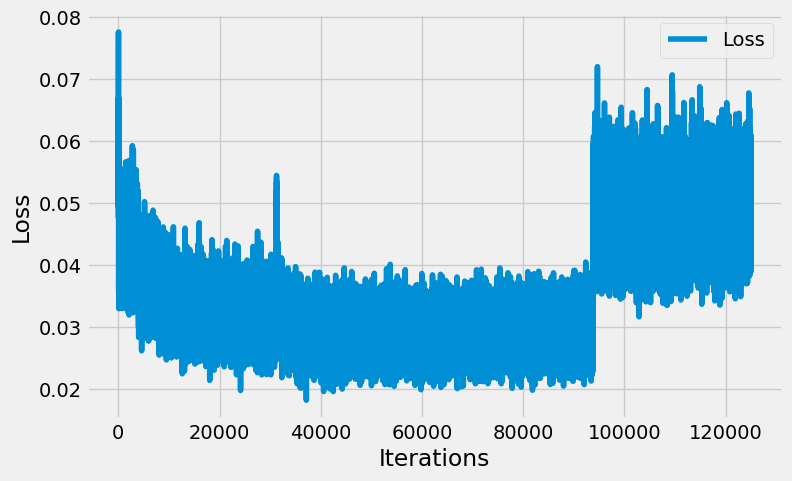

In [25]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

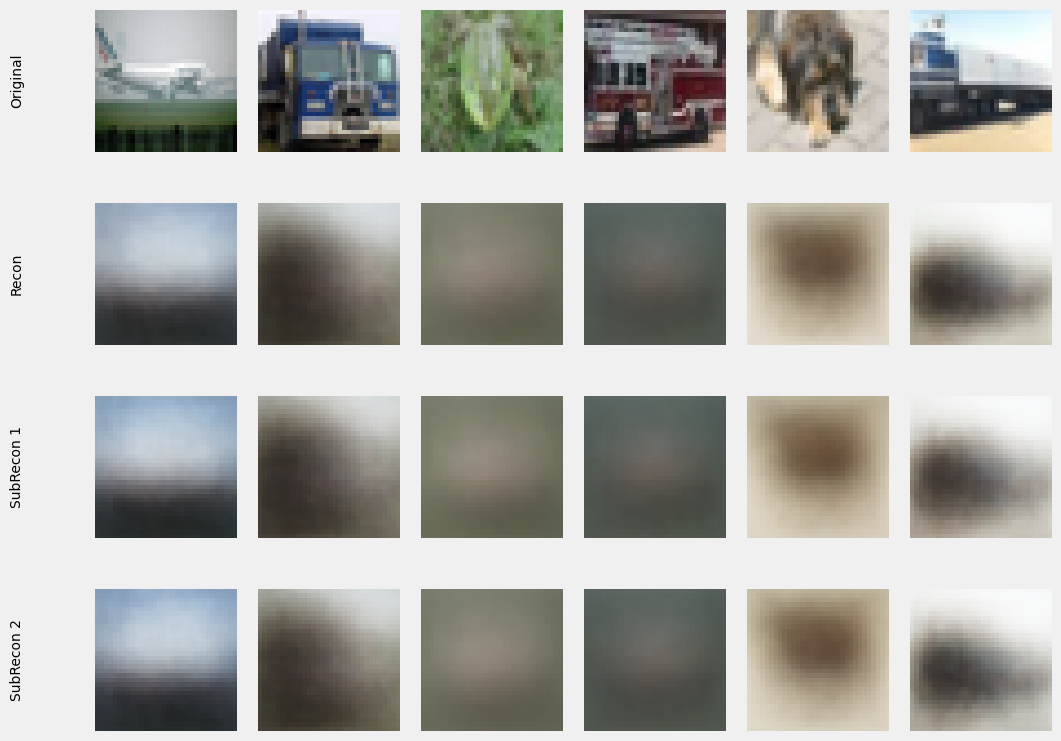

In [26]:
epoch_idx, original_imgs, recon_imgs, first_recon, second_recon, represent = outputs[-1]
n = min(6, original_imgs.size(0))  


original_imgs = original_imgs[:n].detach().cpu().view(-1, 3, 32, 32)
recon_imgs = recon_imgs[:n].detach().cpu().view(-1, 3, 32, 32)
first_recon = first_recon[:n].detach().cpu().view(-1, 3, 32, 32)
second_recon = second_recon[:n].detach().cpu().view(-1, 3, 32, 32)
represent = represent[:n].detach().cpu()  



image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("SubRecon 1", first_recon),
    ("SubRecon 2", second_recon)
]


# rows = len(image_sets)
# plt.figure(figsize=(1.8 * n, 2 * rows))

# for row, (title, img_batch) in enumerate(image_sets):
#     for col in range(n):
#         ax = plt.subplot(rows, n, row * n + col + 1)
#         ax.imshow(img_batch[col], cmap='gray')
#         ax.axis('off')
        

#         if col == 0:
#             ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right', transform=ax.transAxes, rotation=90)

# plt.tight_layout()
# plt.show()

rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)

        img = img_batch[col].permute(1, 2, 0).numpy()
        img = img.clip(0, 1)
        ax.imshow(img)  
        ax.axis('off')

        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right',
                    transform=ax.transAxes, rotation=90)

plt.tight_layout()
plt.show()
